This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fchatelain/parcours-num-exemples/master?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgricad-gitlab.univ-grenoble-alpes.fr%252Fchatelaf%252Fparcours-numerique-ia%26urlpath%3Dlab%252Ftree%252Fparcours-numerique-ia%252Fnotebooks%252F5_regularization/N3_LR_heart_diseases_SA.ipynb%26branch%3Dmaster)

# South Africa Heart Diseases Data
A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of Coranary Heart Disease (CHD). Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

| Variable name     | Description              |
|:---------|:-------------------------|
| sbp	  |	systolic blood **pressure** |
| tobacco	|	cumulative **tobacco** (kg) |
| ldl |		low densiity lipoprotein **cholesterol** |
| adiposity |                                     |
| famhist	 |	**family** history of heart disease (Present=1, Absent=0) |
| typea	|	type-A **behavior** |
| obesity |            |
| alcohol	|	current **alcohol** consumption |
| age		| **age** at onset |
| chd		| **response**: coronary heart disease  (Present=1, Absent=0) |

In [1]:
import pandas as pd
import numpy as np

#load data set
heart = pd.read_csv('SAheart.csv', sep=',', header=0)
heart.head() #data overview: variable names and first values

row.names  sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  \
0          1  160    12.00  5.73      23.11        1     49    25.30    97.20   
1          2  144     0.01  4.41      28.61        0     55    28.87     2.06   
2          3  118     0.08  3.48      32.28        1     52    29.14     3.81   
3          4  170     7.50  6.41      38.03        1     51    31.99    24.26   
4          5  134    13.60  3.50      27.78        1     60    25.99    57.34   

   age  chd  
0   52    1  
1   63    1  
2   46    0  
3   58    1  
4   49    1

In [2]:
y = np.asarray( heart.iloc[:,10], 'float' )
X = np.asarray( heart.iloc[:,1:10], 'float' )
names = list(heart.columns[1:10]) # variable names


# Data matrix X is (n,p) where p is the number of variable and n the number of sample
(n,p)=X.shape
ncases= int(np.sum(y)) # number of cases
print('There is {} samples: {} cases and {:d} control'.format(n,ncases,n-ncases))

There is 462 samples: 160 cases and 302 control


## Compute lasso path

In [3]:
#compute lasso path
from sklearn import linear_model
from time import time
from sklearn.svm import l1_min_c
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Standardize the data! 
# Don't forget that scale matters for penaliezd regression such that Lasso or ridge
# (This is true also for distance based methods s.t. K-NN).
# If one variable has a larger magnitude than the other (imagine that you change the 
# unity for a variable from kilograms to grams), this variable will be much less shrunken than 
# the others.
# Advice: Except if you have a good reason to do the opposite, standardize all your variables 
# to be sure that they are comparable
sc = StandardScaler()
Xs= sc.fit_transform(X) #center  (zero mean) and reduce (unit variance) the variables 

cs = l1_min_c(Xs, y, loss='log') * np.logspace(0, 4, 30)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),
                                      multi_class='multinomial',
                                      warm_start=True)
coefs_ = []
beta_l1norm = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(Xs, y)
    beta_l1norm.append( np.sum(np.abs(clf.coef_.ravel()))) 
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

betas = np.array(coefs_)

Computing regularization path ...
This took 2.441s


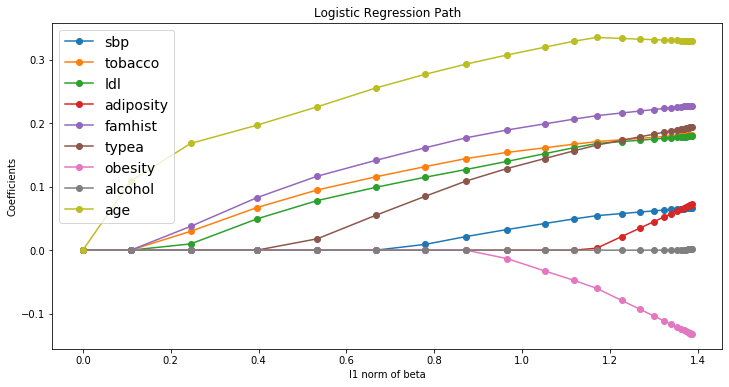

In [4]:
# Display lasso path Vs l1 norm of the coeff vector
plt.figure(figsize=(12,6))
#plt.plot(np.log10(cs), coefs_, marker='o')
plt.plot(beta_l1norm, betas, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('l1 norm of beta')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.legend(names, fontsize=14)
plt.show()

## Cross validation
We estimate the optimal regularization parameter


In [5]:
# K fold cross validation  (K=5)
cs = l1_min_c(Xs, y, loss='log') * np.logspace(0, 2, 50) # the vector fot the alpha (lasso penalty parameter) values
model = linear_model.LogisticRegressionCV(Cs=cs, cv=5, penalty='l1', solver='saga', 
                                  multi_class='multinomial', random_state=2,tol=1e-6).fit(Xs,y)


In [42]:
# Now model is tuned with the penalty parameter estimated by CV
lambda_cv = model.C_[0]
beta_cv = model.coef_.ravel().copy() # the coef estimated with CV
beta_l1norm = np.sum(np.abs(beta_cv))

print('CV estimate lambda = {}, ||beta||_1 = {}\n'.format(lambda_cv,beta_l1norm) )
print('Coefs beta = {}'.format(beta_cv))

CV estimate lambda = 0.06027487268684574, ||beta||_1 = 0.6708959072083218

Coefs beta = [0.         0.11625778 0.09968092 0.         0.14232585 0.05608015
 0.         0.         0.25655121]


### Exercice
- Complete the previous cell to show which are the only significant predictors estimated with cross-validation.
- How can we rank them by significance order? 

#### Click on the dots below for explanations

In [41]:
beta_support = beta_cv.nonzero()[0]
sel_feature= {}
for i in beta_support:
    sel_feature[names[i]]= beta_cv[i]

print('significant variables = {}'.format(sel_feature))

significant variables = {'tobacco': 0.11625777523466398, 'ldl': 0.09968091701290695, 'famhist': 0.14232585329283035, 'typea': 0.05608015312252541, 'age': 0.25655120854539515}


From the Lasso path, we can see that the most significant variable is `age`, then in order  `famhist`, `tobacco`, `ldl` and `typea`